In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn import mixture
import numpy as np
import seaborn as sns
from scipy.stats import kstest, norm, probplot

### Data Loading and Preprocessing

The following code loads a dataset from a text file, assigns column names, separates features from the target variable, and categorizes the features into discrete and continuous types.

In [14]:
data = pd.read_csv('lifeInsurance.txt', header = None, sep= '\s+')
data.columns = ['Gender', 'Age', 'MaritalStatus', 'NumberOfChildren', 'PhysicalStatus', 'ChronicDiseases', 'MonthlySalary', 'Decision']

# Extracting the features and target variable
X = data.drop(columns=["Decision"])
y = data['Decision']

# Separate the discrete and continuous features
discrete_features = ['Gender', 'MaritalStatus', 'NumberOfChildren', 'PhysicalStatus', 'ChronicDiseases']
continuous_features = ['Age', 'MonthlySalary']

# teste.txt example
'''data = pd.read_csv('teste.txt', header = None, sep= '\s+')
data.columns = ['age', 'income', 'student', 'credit', 'Decision']

# Extracting the features and target variable
X = data.drop(columns=["Decision"])
y = data['Decision']

# Separate the discrete and continuous features
discrete_features = ['age', 'income', 'student', 'credit']
continuous_features = []'''

'data = pd.read_csv(\'teste.txt\', header = None, sep= \'\\s+\')\ndata.columns = [\'age\', \'income\', \'student\', \'credit\', \'Decision\']\n\n# Extracting the features and target variable\nX = data.drop(columns=["Decision"])\ny = data[\'Decision\']\n\n# Separate the discrete and continuous features\ndiscrete_features = [\'age\', \'income\', \'student\', \'credit\']\ncontinuous_features = []'

## Prior Probability Calculation Function

The function `prior_probabilities` computes the prior probabilities of each class label in the input vector `y`.

- It counts how many times each unique class appears in `y`.
- It divides each count by the total number of elements to calculate the probability of each class.
- It returns a dictionary where keys are the class labels and values are their corresponding prior probabilities.

In essence, it tells how likely each class is to appear in the dataset before considering any other information.

In [15]:
# Function to calculate prior probabilities for each class label in y
def prior_probabilities(y):
    # Get the total number of elements in y
    total = y.shape[0]
    
    # Create an empty dictionary to store the probabilities
    probabilities = {}

    # Loop through each unique value (class) in y
    for value in y.unique():
        # Count how many times the class appears and divide by total to get the probability
        probabilities[value] = y[y == value].shape[0] / total

    # Return the dictionary with prior probabilities
    return probabilities

# Call the function with y and store the result
prior_prob = prior_probabilities(y)

# Print the prior probabilities
print('Prior probabilities:')
for p, value in prior_prob.items():
    # Display each class and its probability formatted to 4 decimal places
    print(f'  P({p}) = {value:.4f} %')

Prior probabilities:
  P(0.0) = 0.6783 %
  P(1.0) = 0.3217 %


## Conditional Probability for Discrete Features

The function `conditional_probabilities_discrete` calculates **P(feature value | class label)** for each discrete feature in the dataset.

It returns a nested dictionary that stores the probability of observing a specific feature value given a class label.

In [16]:
# Function to compute conditional probabilities P(feature_value | class) for discrete features
def conditional_probabilities_discrete(X, y):
    probabilities = {}  # Initialize an empty dictionary to store probabilities

    # Loop through each discrete feature
    for feature in discrete_features:
        probabilities[feature] = {}  # Initialize a dictionary for each feature

        # Loop through each unique value of the feature
        for value in X[feature].unique():
            probabilities[feature][value] = {}  # Initialize a dictionary for each value of the feature

            # Loop through each unique decision in y
            for decision in y.unique():
                subset = X[(X[feature] == value) & (y == decision)]  # Filter the DataFrame for the current feature value and decision

                num_samples = subset.shape[0]  # Count the number of samples for the current feature value and decision
                num_decision_samples = y[y == decision].shape[0]  # Count the total number of samples for the current decision

                # Calculate the conditional probability P(feature_value | decision)
                probabilities[feature][value][decision] = num_samples / num_decision_samples if num_decision_samples > 0 else 0

    return probabilities

prob_discrete = conditional_probabilities_discrete(X, y)

print('Conditional probabilities for discrete features:')

for feature, values in prob_discrete.items():
    print(f"  Feature: {feature}")
    for value, decisions in values.items():
        print(f"    Value: {value}")
        for decision, prob in decisions.items():
            print(f"      Decision: {decision}, Probability: {prob:.4f}")
    print()

Conditional probabilities for discrete features:
  Feature: Gender
    Value: 0.0
      Decision: 0.0, Probability: 0.8747
      Decision: 1.0, Probability: 0.8238
    Value: 1.0
      Decision: 0.0, Probability: 0.1253
      Decision: 1.0, Probability: 0.1762

  Feature: MaritalStatus
    Value: 1.0
      Decision: 0.0, Probability: 0.4865
      Decision: 1.0, Probability: 0.6425
    Value: 0.0
      Decision: 0.0, Probability: 0.5135
      Decision: 1.0, Probability: 0.3575

  Feature: NumberOfChildren
    Value: 1.0
      Decision: 0.0, Probability: 0.2776
      Decision: 1.0, Probability: 0.2021
    Value: 3.0
      Decision: 0.0, Probability: 0.1990
      Decision: 1.0, Probability: 0.3679
    Value: 2.0
      Decision: 0.0, Probability: 0.2236
      Decision: 1.0, Probability: 0.2798
    Value: 0.0
      Decision: 0.0, Probability: 0.2998
      Decision: 1.0, Probability: 0.1503

  Feature: PhysicalStatus
    Value: 1.0
      Decision: 0.0, Probability: 0.5356
      Decision: 1.0

## Likelihood Calculation for Discrete Features

The function `likelihood_discrete` calculates the likelihood of a given instance belonging to each class label based on the product of conditional probabilities of its discrete feature values. 

It returns a dictionary where each key is a class label and each value is the corresponding likelihood for that class.

In [17]:
# Function to calculate the likelihood for a given instance based on discrete feature probabilities
def likelihood_discrete(prob_discrete, X, y, instance):
    # Initialize a dictionary to store likelihoods for each class
    likelihoods = {}

    # Iterate over each unique decision in y to calculate likelihoods
    for decision in y.unique():
        likelihoods[decision] = 1  # Start with a likelihood of 1 for each decision

        # For each discrete feature, multiply the likelihood by the conditional probability
        for feature in discrete_features:
            value = instance[feature]  # Get the value of the feature for the instance
            likelihoods[decision] *= prob_discrete[feature][value][decision]  # Multiply by the conditional probability for this feature and decision

    return likelihoods

## Gaussian Distribution Check for Continuous Features

The function `check_if_gaussian` checks whether each continuous feature follows a Gaussian (normal) distribution within each class of the target variable `y`.

It uses the **Kolmogorov–Smirnov (KS) test** on standardized data for each feature/class pair and displays:
- The KS test statistic and p-value.
- A **histogram with KDE** to visualize the distribution.
- A **Q–Q plot** to assess normality visually.

If the p-value is greater than 0.05, the feature is likely Gaussian for that class. This function helps determine whether statistical models that assume normality (e.g., Gaussian Naive Bayes) are appropriate for the given data.

Checking if Age is Gaussian...
  Class: 0.0 | KS Statistic: 0.1263, p-value: 0.0000
    The feature Age is not Gaussian.


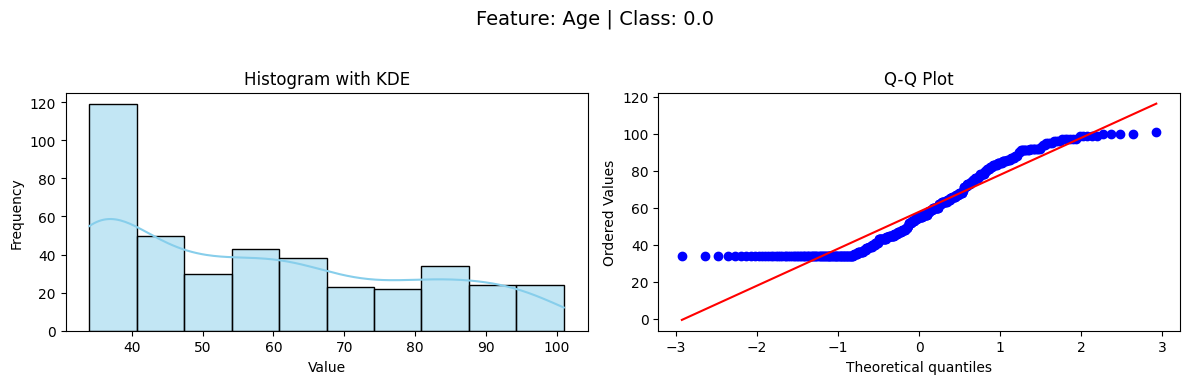

  Class: 1.0 | KS Statistic: 0.0883, p-value: 0.0928
    The feature Age is likely Gaussian.


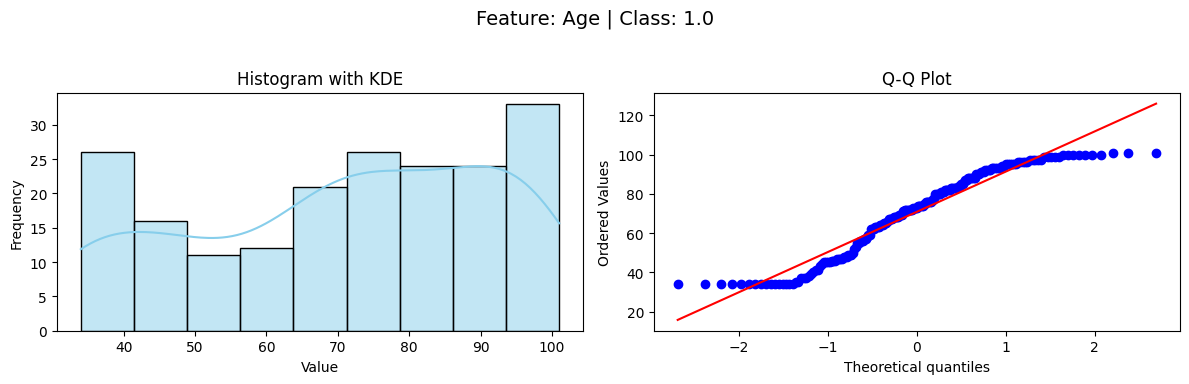

Checking if MonthlySalary is Gaussian...
  Class: 0.0 | KS Statistic: 0.0803, p-value: 0.0099
    The feature MonthlySalary is not Gaussian.


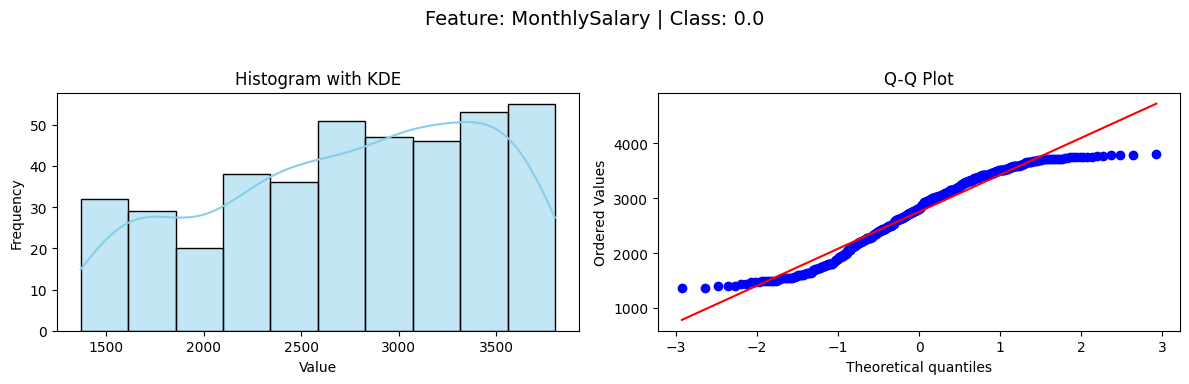

  Class: 1.0 | KS Statistic: 0.0840, p-value: 0.1239
    The feature MonthlySalary is likely Gaussian.


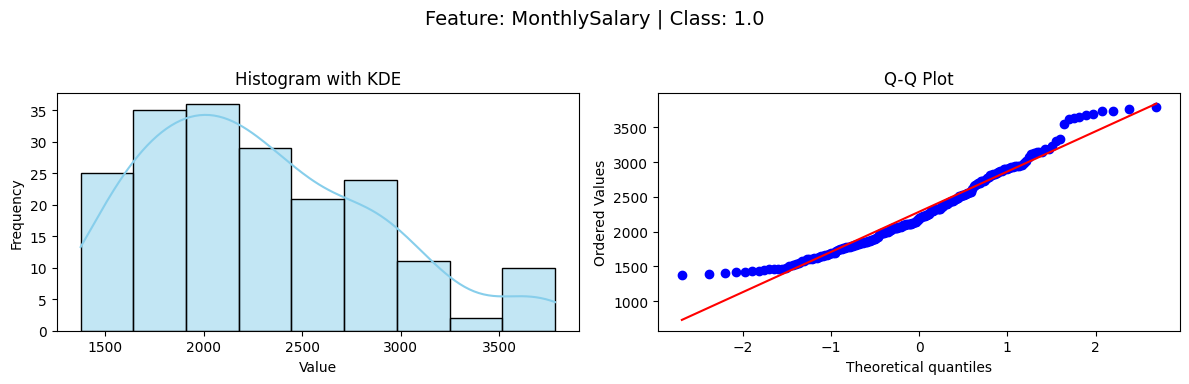

In [18]:
# Function to check if each continuous feature follows a Gaussian distribution for each class
def check_if_gaussian(continuous_features, X, y):
    # Loop through each continuous feature
    for feature in continuous_features:
        print(f"Checking if {feature} is Gaussian...")

        # Loop through each unique decision in y
        for decision in y.unique():
            subset = X[y == decision][feature]  # Filter the DataFrame for the current decision

            # Check if there are enough samples to perform the test
            if len(subset) < 5:
                print(f"  Class: {decision} | Not enough data to test.")
                continue

            mean = subset.mean()  # Calculate the mean of the subset
            std = subset.std()  # Calculate the standard deviation of the subset
            standardized_data = (subset - mean) / std  # Standardize the data. Mean = 0, Std = 1

            stat, p_value = kstest(standardized_data, 'norm')  # Perform the Kolmogorov-Smirnov test

            # Print the results of the test
            print(f"  Class: {decision} | KS Statistic: {stat:.4f}, p-value: {p_value:.4f}")
            if p_value > 0.05:
                print(f"    The feature {feature} is likely Gaussian.")
            else:
                print(f"    The feature {feature} is not Gaussian.")

            # Visualization: Histogram and Q–Q plot
            fig, axes = plt.subplots(1, 2, figsize=(12, 4))
            fig.suptitle(f"Feature: {feature} | Class: {decision}", fontsize=14)

            # Plot histogram with kernel density estimate (KDE) - helps visualize the distribution
            sns.histplot(subset, kde=True, ax=axes[0], color='skyblue')
            axes[0].set_title("Histogram with KDE")
            axes[0].set_xlabel("Value")
            axes[0].set_ylabel("Frequency")

            # Q–Q plot - compares the quantiles of the data against a normal distribution
            # If the points lie on the line, the data is normally distributed
            probplot(subset, dist="norm", plot=axes[1])
            axes[1].set_title("Q-Q Plot")

            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.show()

check_if_gaussian(continuous_features, X, y)

## Mean and Standard Deviation for Continuous Features

The function `mean_std_continuous` calculates the **mean** and **standard deviation** of each continuous feature, separately for every class in the target variable `y`.

**Purpose:** This is useful for models that assume features follow a **Gaussian distribution** per class (e.g., Gaussian Naive Bayes), where the likelihood is computed using these statistics.

In [19]:
# Function to compute the mean and standard deviation of continuous features for each class
def mean_std_continuous(X, y):
    mean_std = {}  # Initialize an empty dictionary to store probabilities

    # Loop through each continuous feature
    for feature in continuous_features:
        mean_std[feature] = {}  # Initialize a dictionary for each continuous feature

        # Loop through each unique decision in y
        for decision in y.unique():
            subset = X[y == decision][feature]  # Filter the DataFrame for the current decision
            mean = subset.mean()  # Calculate the mean of the feature for the current decision
            std = subset.std()  # Calculate the standard deviation of the feature for the current decision

            # Store the mean and standard deviation in the dictionary
            mean_std[feature][decision] = (mean, std)

    return mean_std

print('Mean and standard deviation for continuous features:')
mean_std = mean_std_continuous(X, y)
for feature, decisions in mean_std.items():
    print(f"  Feature: {feature}")
    for decision, (mean, variance) in decisions.items():
        print(f"    Decision: {decision}, Mean: {mean:.4f}, Variance: {variance:.4f}")
    print()

Mean and standard deviation for continuous features:
  Feature: Age
    Decision: 0.0, Mean: 57.8256, Variance: 20.8255
    Decision: 1.0, Mean: 70.8497, Variance: 20.9822

  Feature: MonthlySalary
    Decision: 0.0, Mean: 2752.8421, Variance: 686.7423
    Decision: 1.0, Mean: 2284.9327, Variance: 584.9082



## Conditional Probability Estimation for Continuous Features

To compute the conditional probabilities of continuous features, we will explore the following methods:

- **Gaussian PDF**
- **Discretization**  
- **Gaussian Mixture Models (GMM)**  
- **Kernel Density Estimation (KDE)**
---

### Normal Probability Density Function (Gaussian PDF)  
The normal probability density function assumes that continuous features follow a Gaussian distribution characterized by a mean (`μ`) and standard deviation (`σ`). It calculates the likelihood of observing a specific value based on this distribution. This method is simple and computationally efficient but relies on the assumption that the data is approximately normally distributed.

Mathematically, it is defined as:

$$
P(x \mid \mu, \sigma) = \frac{1}{\sqrt{2\pi\sigma^2}} \cdot e^{ -\frac{(x - \mu)^2}{2\sigma^2} }
$$

In [20]:
# Function to calculate the conditional probabilities of continuous features
# given a data instance, using the normal distribution
# This function assumes that the continuous features follow a Gaussian distribution
def conditional_probabilities_continuous_gaussian(mean_std, X, y, instance):
    probabilities = {}  # Initialize an empty dictionary to store probabilities

    # Loop through each continuous feature
    for feature in continuous_features:
        probabilities[feature] = {}  # Initialize a dictionary for each continuous feature

        # Loop through each unique decision in y
        for decision in y.unique():
            mean, std = mean_std[feature][decision]  # Get the mean and standard deviation for the feature and decision
            value = instance[feature]  # Get the value of the feature for the instance

            prob = norm.pdf(value, loc=mean, scale=std)  # Calculate the probability using the normal PDF

            probabilities[feature][decision] = prob  # Store the probability in the dictionary

    return probabilities

### Discretization  
Discretization involves transforming continuous variables into categorical bins (e.g., intervals or quantiles). This allows us to estimate probabilities using simple frequency counts. While easy to implement, this approach may lead to **loss of information** and depends heavily on how the bins are defined.

In [21]:
def discretize_continuous_features(X, continuous_features, bins=10):
    X_discretized = X.copy()
    
    for feature in continuous_features:
        X_discretized[feature] = pd.cut(X[feature], bins=bins, labels=False)
    
    return X_discretized
# Discretize continuous features
X_discretized = discretize_continuous_features(X, continuous_features)
print('Discretized continuous features:')
print(X_discretized.head())

# A FUNÇÃO NÃO ESTÁ COMPLETA

Discretized continuous features:
   Gender  Age  MaritalStatus  NumberOfChildren  PhysicalStatus  \
0     0.0    6            1.0               1.0             1.0   
1     0.0    9            1.0               3.0             1.0   
2     0.0    0            1.0               3.0             1.0   
3     0.0    0            0.0               1.0             1.0   
4     0.0    8            1.0               2.0             1.0   

   ChronicDiseases  MonthlySalary  
0              0.0              5  
1              1.0              7  
2              1.0              4  
3              1.0              6  
4              1.0              4  


### Gaussian Mixture Models (GMM)  
GMMs model the probability distribution as a combination of multiple Gaussian components. This makes them ideal for approximating **non-Gaussian or multimodal distributions**. They estimate the **likelihood** of a value more accurately than a single Gaussian in complex cases, which improves classification performance when used in probabilistic classifiers.

In [22]:
# FAZER A FUNÇÃO USANDO GMM

### Kernel Density Estimation (KDE)  
KDE is a non-parametric way to estimate the probability density function of a random variable. It does not assume any specific distribution, making it flexible for modeling complex or unknown distributions. However, KDE can be computationally expensive and sensitive to bandwidth selection.

In [23]:
# FAZER A FUNÇÃO USANDO KDE

In [24]:
# Define a new data instance with both discrete and continuous features
instance = {
    'Gender': 0,
    'Age': 50,
    'MaritalStatus': 1,
    'NumberOfChildren': 2,
    'PhysicalStatus': 1,
    'ChronicDiseases': 0,
    'MonthlySalary': 3000
}

'''instance = {
    'age': 0,
    'income': 1,
    'student': 1,
    'credit': 0
}'''

# Compute likelihoods for the discrete features of the instance, 
# using precomputed conditional probabilities (P(feature=value | class))
likelihoods_discrete = likelihood_discrete(prob_discrete, X, y, instance)

print('Likelihoods for the instance:')
for decision, prob in likelihoods_discrete.items():
    print(f'  P(Decision={decision} | Instance) = {prob:.4f}')
print()

# Compute conditional probabilities for the continuous features
# using the Gaussian probability density function
prob_continuous = conditional_probabilities_continuous_gaussian(mean_std, X, y, instance)

print('Conditional probabilities for continuous features:')
for feature, decisions in prob_continuous.items():
    print(f"  Feature: {feature}")
    for decision, prob in decisions.items():
        print(f"    Decision: {decision}, Probability: {prob:.4f}")
    print()

Likelihoods for the instance:
  P(Decision=0.0 | Instance) = 0.0319
  P(Decision=1.0 | Instance) = 0.0154

Conditional probabilities for continuous features:
  Feature: Age
    Decision: 0.0, Probability: 0.0179
    Decision: 1.0, Probability: 0.0116

  Feature: MonthlySalary
    Decision: 0.0, Probability: 0.0005
    Decision: 1.0, Probability: 0.0003



In [25]:
# TODO
# fazer multiplicação das probabilidades continuas
# multiplicar com as discretas
# e multiplicar com a probabilidade a priori
# laplace smoothing for discrete features 